# ``SimpleConvNet2d`` Demo

To use this demo, build the conda env defined in ``requirements-dev.conda.yaml``.

The ``torch_tools.SimpleConvNet2d`` is a small, simple, 2D CNN model.

## Classifying handwritten digits — MNIST

The MNIST dataset contains greyscale images of `(28,28)` pixels containing handwritten digits between zero and nine. It is very easy to access the MNIST data through ``torchvision``—so much so that we don't even need to use the custom ``torch_tools.DataSet`` class.

So, let's get some digits!

### Demo env
Remember: the demo env requirements file—``demo-requirements.conda.yaml``—is different from the standard ``requirements.conda.yaml``. See ``README.md``.

In [1]:
from torchvision.datasets import MNIST
from torch import eye
from torchvision.transforms import Compose, ToTensor, RandomRotation
from torchvision.transforms import ColorJitter

import matplotlib.pyplot as plt

train_set = MNIST(
    "~/mnist_data/",
    download=True,
    train=True,
    transform=Compose(
        [
            ToTensor(),
            ColorJitter(brightness=0.2),
            RandomRotation(180),
        ]
    ),
    target_transform=Compose([lambda x: eye(10)[x]]),
)

valid_set = MNIST(
    "~/mnist_data/",
    download=True,
    train=False,
    transform=Compose([ToTensor()]),
    target_transform=Compose([lambda x: eye(10)[x]]),
)

print(len(train_set), len(valid_set))

60000 10000


Since we have done quite a few things here, let's break them down.

- The ``transform`` argument:
  - we supply a ``torchvision.transfroms.Compose`` object, which simply lets you chain callable objects to modify the images.
  - the first thing in the ``Compose`` is a ``torchvision.transforms.ToTensor``, which converts PIL images (or numpy image-like arrays) to ``torch.Tensor``s.
  - the second item is Torchvision's random rotation object, which in this case, randomly rotates the images by [-180, 180] degrees.
  - the final item is an object for augmenting the colour of the images.
- The ``target_transform`` argument:
  - The target for each image is simply encoded as an integer. ``0`` means the image contains a zero, ``1`` means the image contains a one, etc. We convert these indices to one-hot encoded vectors with the lambda function supplued to ``target_transfrom``.

Let's look at a single example.

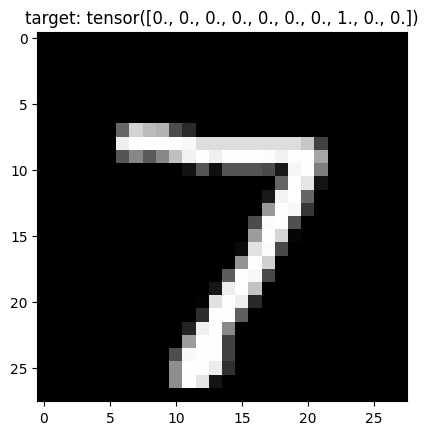

In [2]:
img, target = valid_set[0]

plt.imshow(img.permute(1, 2, 0), cmap="Greys_r")
plt.title(f"target: {target}")
plt.show()

This example is clearly a seven, and the target is a one-hot vector encoding the fact that the ground truth is a 7.

As before, we now wrap the datasets in ``torch.utils.data.DataLoader``.

In [3]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_set, shuffle=False, batch_size=batch_size)

As before, we need a model, optimiser and a loss function.

In [4]:
from torch_tools import SimpleConvNet2d
from torch.cuda import is_available

DEVICE = "cuda" if is_available() else "cpu"

model = SimpleConvNet2d(
    in_chans=1,
    out_feats=10,
    kernel_size=3,
    num_blocks=3,
    block_style="conv_res",
).to(DEVICE)
print(model)

SimpleConvNet2d(
  (0): Encoder2d(
    (0): ConvResBlock(
      (0): ConvBlock(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
      )
      (1): ResidualBlock(
        (first_conv): ConvBlock(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.0)
        )
        (second_conv): ConvBlock(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (relu): ReLU()
      )
    )
    (1): DownBlock(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): ConvResBlo

Now, lets set up a loss function and optimiser.

In [5]:
from torch.nn import BCELoss
from torch.optim import Adam

loss_func = BCELoss(reduction="sum")
optimiser = Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

And now, the training and validation loops.

In [6]:
from torch import no_grad


def train_one_epoch(
    train_loader: DataLoader,
    loss_func: BCELoss,
    optimiser: Adam,
    model: SimpleConvNet2d,
):
    """Train the model for a single epoch.

    Parameters
    ----------
    train_loader : DataLoader
        A data loader supplying the training data.
    loss_func : BCELoss
        The loss function.
    optimiser : Adam
        Optimiser to fit the model with.
    model : SimpleConvNet2d
        Classification model.

    Returns
    -------
    mean_loss : float
        Mean loss per item.
    accuracy : float
        Fraction of inputs correctly classified.

    """
    model.train()
    running_loss = 0.0
    correct = 0
    for batch, targets in train_loader:
        batch, targets = batch.to(DEVICE), targets.to(DEVICE)

        optimiser.zero_grad()

        preds = model(batch).softmax(dim=1)

        loss = loss_func(preds, targets)

        loss.backward()

        optimiser.step()

        running_loss += loss.item()

        correct += (
            (preds.argmax(dim=1).detach().cpu() == targets.cpu().argmax(dim=1))
            .sum()
            .item()
        )

    mean_loss = running_loss / len(train_loader.dataset)
    accuracy = correct / len(train_loader.dataset)

    return mean_loss, accuracy


@no_grad()
def validate_one_epoch(
    valid_loader: DataLoader,
    loss_func: BCELoss,
    model: SimpleConvNet2d,
):
    """Validate the model for a single epoch.

    Parameters
    ----------
    valid_loader : DataLoader
        Validation data loader.
    loss_func : BCELoss
        Loss function
    model : SimpleConvNet2d
        Classification model.

    Returns
    -------
    mean_loss : float
        The mean loss per item.
    accuracy : float
        The fraction of correctly classified inputs.

    """
    model.eval()
    running_loss = 0.0
    correct = 0
    for batch, targets in valid_loader:
        batch, targets = batch.to(DEVICE), targets.to(DEVICE)

        preds = model(batch).softmax(dim=1)

        loss = loss_func(preds, targets)

        running_loss += loss.item()

        correct += (
            (preds.argmax(dim=1).detach().cpu() == targets.argmax(dim=1).cpu())
            .sum()
            .item()
        )

    mean_loss = running_loss / len(valid_loader.dataset)
    accuracy = correct / len(valid_loader.dataset)

    return mean_loss, accuracy

Now we can train the model.

In [7]:
from time import perf_counter

num_epochs = 20

training_loss, validation_loss = [], []
training_acc, validation_acc = [], []

for epoch in range(num_epochs):
    start = perf_counter()

    train_loss, train_acc = train_one_epoch(
        train_loader,
        loss_func,
        optimiser,
        model,
    )
    valid_loss, valid_acc = validate_one_epoch(valid_loader, loss_func, model)

    stop = perf_counter()

    print(f"Epoch {epoch + 1} time = {stop - start:.2f} seconds")

    training_loss.append(train_loss)
    training_acc.append(train_acc)

    validation_loss.append(valid_loss)
    validation_acc.append(valid_acc)

Epoch 1 time = 19.75 seconds
Epoch 2 time = 19.44 seconds
Epoch 3 time = 19.50 seconds
Epoch 4 time = 19.44 seconds
Epoch 5 time = 19.46 seconds
Epoch 6 time = 19.57 seconds
Epoch 7 time = 19.47 seconds
Epoch 8 time = 19.51 seconds
Epoch 9 time = 19.65 seconds
Epoch 10 time = 19.49 seconds
Epoch 11 time = 19.48 seconds
Epoch 12 time = 19.50 seconds
Epoch 13 time = 19.57 seconds
Epoch 14 time = 19.83 seconds
Epoch 15 time = 19.88 seconds
Epoch 16 time = 19.94 seconds
Epoch 17 time = 19.95 seconds
Epoch 18 time = 20.00 seconds
Epoch 19 time = 19.56 seconds
Epoch 20 time = 19.50 seconds


Now let's plot some simple performance metrics.

    train_loss  valid_loss  train_acc  valid_acc
0     0.728553    0.270118   0.869483     0.9553
1     0.312370    0.289103   0.946083     0.9489
2     0.248789    0.165301   0.957417     0.9690
3     0.219789    0.153254   0.962433     0.9742
4     0.193247    0.198911   0.966583     0.9615
5     0.174270    0.167609   0.969583     0.9710
6     0.164863    0.091119   0.971300     0.9841
7     0.151352    0.100349   0.973650     0.9826
8     0.147212    0.111615   0.975050     0.9800
9     0.140978    0.099731   0.975733     0.9827
10    0.134165    0.120497   0.976767     0.9790
11    0.128277    0.103530   0.978217     0.9827
12    0.123615    0.073463   0.979383     0.9875
13    0.117724    0.090144   0.979983     0.9844
14    0.117566    0.108165   0.979517     0.9820
15    0.111860    0.073126   0.980333     0.9880
16    0.107505    0.078250   0.981717     0.9866
17    0.102992    0.108636   0.981933     0.9811
18    0.101692    0.095310   0.982100     0.9831
19    0.102814    0.

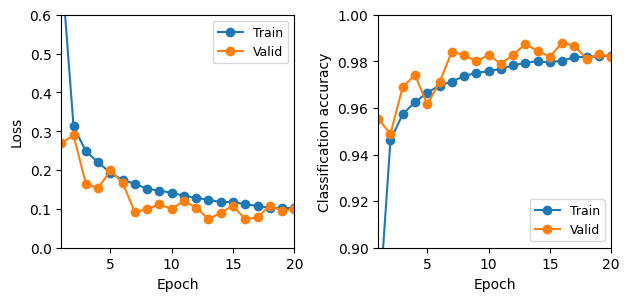

In [12]:
from pandas import DataFrame
from numpy import diff, linspace

metrics = DataFrame(
    columns=["train_loss", "valid_loss", "train_acc", "valid_acc"],
    data=zip(
        training_loss,
        validation_loss,
        training_acc,
        validation_acc,
    ),
)

print(metrics)


fig, axes = plt.subplots(1, 2)

x_points = linspace(1, len(metrics), len(metrics))

axes[0].plot(x_points, metrics.train_loss, "-o", label="Train")
axes[0].plot(x_points, metrics.valid_loss, "-o", label="Valid")

axes[1].plot(x_points, metrics.train_acc, "-o", label="Train")
axes[1].plot(x_points, metrics.valid_acc, "-o", label="Valid")


for axis in axes.ravel():
    axis.set_xlim(left=x_points.min(), right=x_points.max())
    axis.set_xlabel("Epoch")

axes[0].set_ylim(bottom=0.0, top=0.6)
axes[1].set_ylim(bottom=0.90, top=1.0)

for axis in axes.ravel():
    axis.legend(fontsize=9)
    axis.set_aspect(
        diff(axis.get_xlim()) / diff(axis.get_ylim()),
    )

axes[0].set_ylabel("Loss")
axes[1].set_ylabel("Classification accuracy")


fig.tight_layout()

## Visualising features with TSNE

First, we run over the validation loader and save the features for each item.

In [9]:
from torch import concat

model.eval()

features, tgts = [], []

for batch, targets in valid_loader:

    with no_grad():
        feats = model.get_features(batch.to(DEVICE)).cpu()

    features.append(feats)
    tgts.append(targets.argmax(dim=1))


features = concat(features, dim=0)
targets = concat(tgts, dim=0)

Now we reduce the dimensionality of the features using the TSNE method.

In [10]:
from sklearn.manifold import TSNE

embedded = TSNE(n_components=2).fit_transform(features)

data = DataFrame()
data["target"] = targets
data[["x", "y"]] = embedded

Now, we plot the features and colour them by the ground truth.

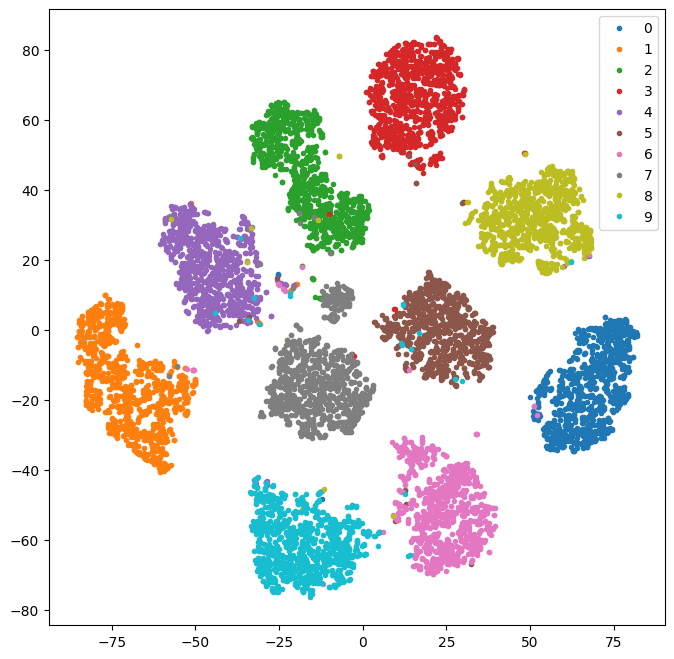

In [11]:
figure, axis = plt.subplots(1, 1, figsize=(8, 8))

for number, frame in data.groupby("target"):
    axis.plot(frame.x, frame.y, ".", label=number)

axis.set_aspect(
    diff(axis.get_xlim()) / diff(axis.get_ylim()),
)

axis.legend()

There are clearly nine clusters, as we should expect, though arguably something weird is going on with they grey (seven) cluster.